In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-07-10 02:24:58--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  88.1MB/s    in 0.7s    

2020-07-10 02:24:59 (88.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
import os
import zipfile

In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print('\n', train_dog_fnames[:10])

['cat.955.jpg', 'cat.776.jpg', 'cat.914.jpg', 'cat.467.jpg', 'cat.784.jpg', 'cat.868.jpg', 'cat.696.jpg', 'cat.606.jpg', 'cat.219.jpg', 'cat.687.jpg']

 ['dog.119.jpg', 'dog.723.jpg', 'dog.1.jpg', 'dog.638.jpg', 'dog.366.jpg', 'dog.735.jpg', 'dog.15.jpg', 'dog.544.jpg', 'dog.979.jpg', 'dog.238.jpg']


In [ ]:
print(f'Total Training Cats: {len(os.listdir(train_cats_dir))}')
print(f'Total Training Dogs: {len(os.listdir(train_dogs_dir))}')

print(f'\nTotal Validation Cats: {len(os.listdir(validation_cats_dir))}')
print(f'Total Validation Dogs: {len(os.listdir(validation_dogs_dir))}')

Total Training Cats: 1000
Total Training Dogs: 1000

Total Validation Cats: 500
Total Validation Dogs: 500


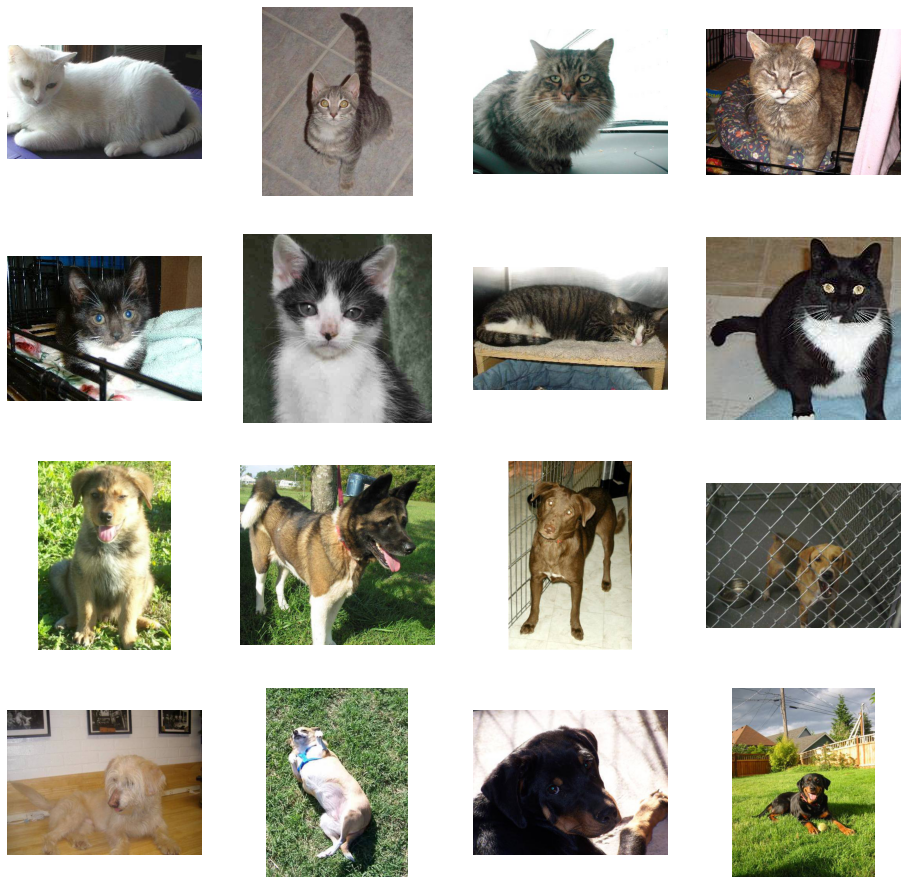

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images


fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(63, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 63)        18207     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 63)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18207)            

In [ ]:
from keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [ ]:
class mycallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') >= 0.75:
            print('\nReached Desired 75% accuracy !!!')
            self.model.stop_training = True

callback = mycallback()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150,150))

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size=20,
                                                        class_mode='binary',
                                                        target_size=(150,150))



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_data=validation_generator,
                              validation_steps=50,
                              verbose=2,
                              callbacks=[callback])

Epoch 1/15
 - 64s - loss: 0.7907 - accuracy: 0.5745 - val_loss: 0.6202 - val_accuracy: 0.6420
Epoch 2/15
 - 62s - loss: 0.6214 - accuracy: 0.6735 - val_loss: 0.5467 - val_accuracy: 0.5510
Epoch 3/15
 - 62s - loss: 0.5366 - accuracy: 0.7325 - val_loss: 1.1431 - val_accuracy: 0.6900
Epoch 4/15
 - 62s - loss: 0.4743 - accuracy: 0.7815 - val_loss: 0.5187 - val_accuracy: 0.6910
Epoch 5/15
 - 62s - loss: 0.3816 - accuracy: 0.8290 - val_loss: 0.7055 - val_accuracy: 0.7070
Epoch 6/15
 - 62s - loss: 0.2934 - accuracy: 0.8720 - val_loss: 0.7242 - val_accuracy: 0.7020
Epoch 7/15
 - 62s - loss: 0.2138 - accuracy: 0.9100 - val_loss: 0.4526 - val_accuracy: 0.7000
Epoch 8/15
 - 62s - loss: 0.1484 - accuracy: 0.9465 - val_loss: 0.5719 - val_accuracy: 0.6960
Epoch 9/15
 - 62s - loss: 0.1145 - accuracy: 0.9585 - val_loss: 0.9356 - val_accuracy: 0.7290
Epoch 10/15
 - 62s - loss: 0.0676 - accuracy: 0.9760 - val_loss: 0.5757 - val_accuracy: 0.7120
Epoch 11/15
 - 62s - loss: 0.0930 - accuracy: 0.9745 - val_

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

# keys contain the name of the file which can be used for getting the path of the file
for filename in uploaded.keys(): 
  path = '/content/' + filename
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x,axis=0)
  images = np.vstack([x])
  classes = model.predict(images)
  print(classes[0])
  if classes[0] > 0.5:
    print(filename + " is a dog")
  else:
    print(filename + " is a cat")

Saving cat-3.jpg to cat-3.jpg
[0.]
cat-3.jpg is a cat
